Importing and Preprocessing

In [ ]:
!pip install datasets skorch pandas numpy tensorflow numba

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timeit import default_timer as timer
from numba import cuda
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%script false --no-raise-error

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = np.reshape(a=x_train, newshape=(len(x_train), x_train.shape[1], x_train.shape[2]))
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(a=x_test, newshape=(len(x_test), x_test.shape[1], x_test.shape[2]))


In [ ]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_train = np.reshape(a=x_train, newshape=(len(x_train), x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(a=x_test, newshape=(len(x_test), x_test.shape[1], x_test.shape[2], x_test.shape[3]))

170498071/170498071 [==============================] - 13s 0us/step


Autoencoder for anomaly detection

In [ ]:
img_shape = x_train[0].shape #+ (1,)

In [ ]:
class Autoencoder(tf.keras.models.Model):
  def __init__(self, shape, latent_dim: int, enc_layers: list, dec_layers: list, act_fun: str = 'relu'):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder, self.decoder = tf.keras.Sequential(name="encoder"), tf.keras.Sequential(name="decoder")

    self.encoder.add(tf.keras.layers.Input(shape=self.shape)) #input layer
    for i, (filters, kernel_size) in enumerate(enc_layers): # adding the encoding layers
      if i % 2 == 1:
        self.encoder.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation=act_fun, padding='same'))
      self.encoder.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=act_fun, padding='same'))
      self.encoder.add(tf.keras.layers.BatchNormalization())
      #self.encoder.add(tf.keras.layers.MaxPooling2D((2,2), padding='same'))


    for i, (filters, kernel_size) in enumerate(dec_layers): # adding the encoding layers
      if i % 2 == 1:
        self.decoder.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation=act_fun, padding='same'))
      self.decoder.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=act_fun, padding='same'))
      self.decoder.add(tf.keras.layers.BatchNormalization())
      self.decoder.add(tf.keras.layers.UpSampling2D((2,2)))

    self.decoder.add(tf.keras.layers.Resizing(height=self.shape[0], width=self.shape[1]))
    self.decoder.add(tf.keras.layers.Conv2D(filters=3, kernel_size=3, activation='sigmoid', padding='same'))



  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
enc_layers = [(32,3), (32,3)] #
dec_layers = [(32,3)]
autoencoder = Autoencoder(shape=img_shape, latent_dim=64, enc_layers=enc_layers, dec_layers=dec_layers, act_fun='relu')

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'], loss='mse')

In [ ]:
import gc
gc.collect()

35967

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True, min_delta=.0001)
history = autoencoder.fit(x=x_train, y=x_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          callbacks=[early_stopping])

Epoch 1/50
196/196 [==============================] - 9s 32ms/step - loss: 0.0079 - accuracy: 0.6552 - val_loss: 0.0286 - val_accuracy: 0.5697
Epoch 2/50
196/196 [==============================] - 5s 23ms/step - loss: 0.0023 - accuracy: 0.7534 - val_loss: 0.0087 - val_accuracy: 0.6882
Epoch 3/50
196/196 [==============================] - 4s 22ms/step - loss: 0.0016 - accuracy: 0.7798 - val_loss: 0.0018 - val_accuracy: 0.7799
Epoch 4/50
196/196 [==============================] - 5s 25ms/step - loss: 0.0013 - accuracy: 0.7951 - val_loss: 0.0015 - val_accuracy: 0.8080
Epoch 5/50
196/196 [==============================] - 5s 23ms/step - loss: 0.0011 - accuracy: 0.8089 - val_loss: 0.0013 - val_accuracy: 0.8212
Epoch 6/50
196/196 [==============================] - 5s 25ms/step - loss: 9.2562e-04 - accuracy: 0.8202 - val_loss: 9.7326e-04 - val_accuracy: 0.8373
Epoch 7/50
196/196 [==============================] - 5s 28ms/step - loss: 8.2258e-04 - accuracy: 0.8291 - val_loss: 0.0010 - val_accu

In [ ]:
autoencoder.summary()

Model: "autoencoder_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 16, 16, 32)        19648     
                                                                 
 decoder (Sequential)        (None, 32, 32, 3)         10243     
                                                                 
Total params: 29891 (116.76 KB)
Trainable params: 29699 (116.01 KB)
Non-trainable params: 192 (768.00 Byte)
_________________________________________________________________


In [ ]:
autoencoder.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_132 (B  (None, 32, 32, 32)        128       
 atchNormalization)                                              
                                                                 
 conv2d_73 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 conv2d_74 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_133 (B  (None, 16, 16, 32)        128       
 atchNormalization)                                              
                                                                 
Total params: 19648 (76.75 KB)
Trainable params: 19520 (76.

In [ ]:
autoencoder.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_134 (B  (None, 16, 16, 32)        128       
 atchNormalization)                                              
                                                                 
 up_sampling2d_26 (UpSampli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 resizing_6 (Resizing)       (None, 32, 32, 32)        0         
                                                                 
 conv2d_76 (Conv2D)          (None, 32, 32, 3)         867       
                                                                 
Total params: 10243 (40.01 KB)
Trainable params: 10179 (39.

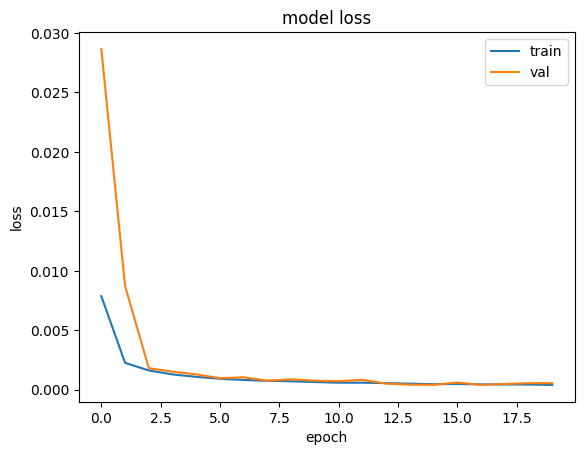

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

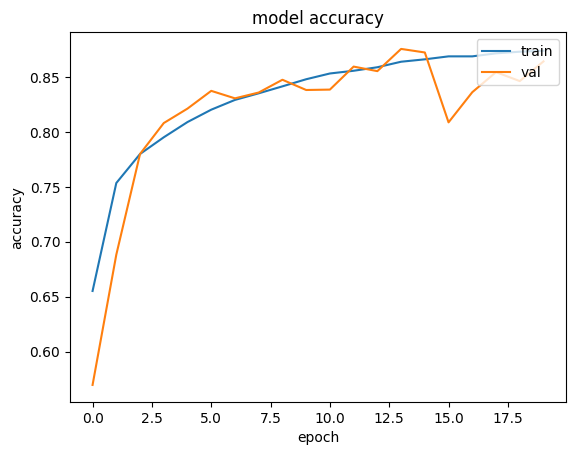

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
test_image = np.reshape(a=x_test[5], newshape=(1, 32, 32, 3))
reconstructed_image = autoencoder(test_image)

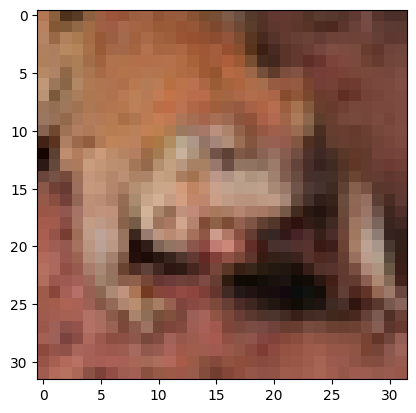

In [ ]:
plt.imshow(x_test[5])
plt.show()

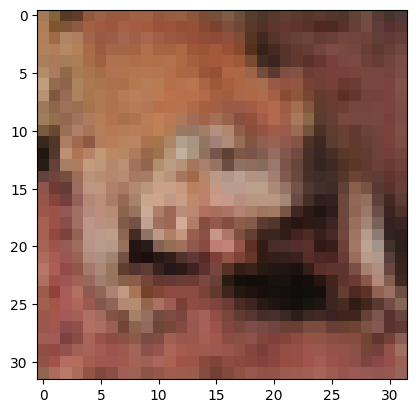

In [ ]:
plt.imshow(np.reshape(a=reconstructed_image, newshape=img_shape))
plt.show()

In [ ]:
autoencoder.save("autoencoder_model_CNN", save_format="tf")

In [ ]:
!zip -r "autoencoder_model_CNN.zip" "/content/autoencoder_model_CNN"

  adding: content/autoencoder_model_CNN/ (stored 0%)
  adding: content/autoencoder_model_CNN/saved_model.pb (deflated 89%)
  adding: content/autoencoder_model_CNN/assets/ (stored 0%)
  adding: content/autoencoder_model_CNN/variables/ (stored 0%)
  adding: content/autoencoder_model_CNN/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/autoencoder_model_CNN/variables/variables.index (deflated 70%)
  adding: content/autoencoder_model_CNN/keras_metadata.pb (deflated 92%)
  adding: content/autoencoder_model_CNN/fingerprint.pb (stored 0%)
